# **Automated Detection of Gender Discriminatory Remarks Online: Based on BERT and Logistic Regression Models**

*Sexism is still a serious problem in contemporary society, and it exists in various forms in online forums, social media platforms, and everyday communication. With the advent of the digital age, cyberspace has become a prime place for people to express their views, share experiences and exchange ideas, but unfortunately, it has also become a new avenue for sexist speech to spread. It is therefore critical to effectively identify and respond to online sexism.*

*By utilizing advanced NLP technology, we can automatically detect and analyze sexist speech patterns, thereby helping to reduce sexism in cyberspace. This code applies BERT (Bidirectional Encoder Representations from Transformers) model and logistic regression model to detect and analyze sexist speech in online content. The performance of the two models is also compared.*

In [ ]:
# Install the necessary libraries
!pip install emoji transformers nltk

import torch
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from tqdm import tqdm
import emoji
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download the necessary nltk data packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Check and set up the device**

In [ ]:
# Check and set up the device, preferring to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use：{device}")


Device in use：cuda


**Import the dataset**

In [ ]:
# Import the dataset
df = pd.read_csv('twitter_sexism_parsed_dataset.csv')

# Remove rows where the 'oh_label' column has NaN values
df = df.dropna(subset=['oh_label'])

# Convert the 'oh_label' column to integer type to ensure label consistency
df['oh_label'] = df['oh_label'].astype(int)

**Data preprocessing-BERT**

In [ ]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def enhanced_clean_text(text):
    """
    Cleans the input text by handling censored words, preserving specific formatting
    like all caps, and removing extra spaces, while maintaining the original case.
    """
    # Handle censored words by replacing placeholder with <censored>
    text = re.sub(r'\$\$\$', '<censored>', text)
    # Preserve words in all caps but add <allcaps> tags around them
    text = re.sub(r'([A-Z]{2,})', r'<allcaps> \1 </allcaps>', text)
    # Keep emoticons and specific punctuation, no removal of all non-letter characters here
    # Remove extra spaces and leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Original case of the text is preserved
    return text

def preprocess_emojis(text):
    """
    Converts emojis to their corresponding text description.
    """
    return emoji.demojize(text)

def preprocess_text(text):
    """
    Processes the input text through various steps: cleaning, emoji handling,
    tokenizing, and lemmatizing. This function aims to prepare text for
    further analysis or machine learning models.
    """
    # Clean the text
    text = enhanced_clean_text(text)
    # Convert emojis to text
    text = preprocess_emojis(text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Reassemble the text from lemmatized tokens
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text


# Function for preprocessing and encoding texts
def preprocess_texts(texts):
    """
    Preprocesses and encodes a list of texts using a tokenizer. The tokenizer
    applies padding and truncation to ensure uniform length and converts the texts
    to model-compatible tensors.

    """
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Preprocess and encode the texts in the dataset
df['cleaned_text'] = df['Text'].apply(preprocess_text)


**Defining a BERT Classifier Model**

In [ ]:
class BertClassifierWithDropout(torch.nn.Module):
    def __init__(self, dropout_prob=0.01):
        """
        Initializes the BERT classifier with an additional dropout layer.

        Args:
        - dropout_prob (float): Probability of dropping out a neuron, helps prevent overfitting.
        """
        super(BertClassifierWithDropout, self).__init__()
        # Load the BERT model from the Hugging Face library
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Initialize a Dropout layer; dropout_prob determines the dropout rate
        self.dropout = torch.nn.Dropout(dropout_prob)
        # Initialize a linear layer for classification;
        # it maps from the BERT hidden state size to 2 output features for binary classification
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model for calculating logits.

        Args:
        - input_ids (tensor): Tensor of token ids to be fed to BERT.
        - attention_mask (tensor): Tensor specifying which tokens should be attended to, and which should not.

        Returns:
        - logits (tensor): The output logits from the classifier layer.
        """
        # Pass input_ids and attention_mask to the BERT model
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        # Extract the last hidden state of the first token ([CLS] token) as the pooled output
        pooled_output = outputs.last_hidden_state[:, 0, :]
        # Apply dropout to the pooled output
        pooled_output = self.dropout(pooled_output)
        # Apply the classifier to the pooled output to get the logits
        logits = self.classifier(pooled_output)
        return logits


**Preparing for K-Fold Cross-Validation**

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertTokenizer, AdamW
from tqdm.auto import tqdm
from rich.console import Console
from rich.table import Table
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
console = Console()

In [ ]:
# Initialize K-Fold cross-validation with 5 splits, shuffling enabled, and a fixed random state for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the names of the target categories for use in reporting results
target_names = ['non-sexism', 'sexism']

# Initialize a list to store the results from each cross-validation fold
results = []

# Initialize lists to store all true labels, predicted labels, and predicted probabilities for all folds
all_true_labels = []
all_preds_list = []
all_pred_probs = []

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Initialize the loss function outside the loop, using CrossEntropyLoss suitable for classification tasks
loss_fct = torch.nn.CrossEntropyLoss()


**Training and Validating the Model-BERT**

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f'Fold {fold + 1}')

    # Data Splitting
    # Divide the dataset into training and validation sets based on indices from the KFold split
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

    # Class Balancing
    # Separate the majority and minority classes in the training dataset
    df_majority = train_df[train_df['oh_label'] == 0]
    df_minority = train_df[train_df['oh_label'] == 1]
    # Upsample the minority class to match the number of samples in the majority class, for balancing
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=123)
    # Combine the majority class with the upsampled minority class to create a balanced training dataset
    train_df_balanced = pd.concat([df_majority, df_minority_upsampled])

    # BERT Tokenizer Initialization
    # Load the base version of the BERT model and tokenizer
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Preprocess and encode the dataset texts
    # Apply preprocessing and encoding to the cleaned texts of the balanced training dataset
    train_encodings = preprocess_texts(train_df_balanced['cleaned_text'])
    # Apply the same preprocessing and encoding steps to the validation dataset texts
    val_encodings = preprocess_texts(val_df['cleaned_text'])

    # Create TensorDataset
    # Create a TensorDataset for the training data with input_ids, attention masks, and labels
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_df_balanced['oh_label'].values))
    # Repeat the process for the validation data
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_df['oh_label'].values))

    # DataLoader setup
    # Set the batch size for training and validation
    batch_size = 64
    # Initialize the DataLoader for the training data with random shuffling
    train_loader = DataLoader(train_dataset, sampler=torch.utils.data.RandomSampler(train_dataset), batch_size=batch_size)
    # Initialize the DataLoader for the validation data without shuffling (sequential)
    val_loader = DataLoader(val_dataset, sampler=torch.utils.data.SequentialSampler(val_dataset), batch_size=batch_size)

    # Load the BERT model
    # Initialize the BERT classifier model with dropout for training
    model = BertClassifierWithDropout()
    # Ensure the model is sent to the correct device (GPU or CPU)
    model.to(device)

    # Define the optimizer
    # AdamW is a class of Adam optimized with weight decay fix, suitable for BERT
    optimizer = AdamW(model.parameters(), lr=5e-7, eps=1e-8, weight_decay=0.1)

    # Define the learning rate scheduler
    # ReduceLROnPlateau reduces the learning rate when a metric has stopped improving,
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    epochs = 5

    # Initialize the best validation loss for early stopping mechanism
    best_val_loss = float('inf')

    # Set patience for early stopping (how many epochs to wait after last time validation loss improved)
    patience = 2

    # Initialize trigger times for counting how many times the early stopping condition is met
    trigger_times = 0


    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        # Training
        model.train()
        total_loss = 0
        total_train_accuracy = 0

        # Wrap train_loader with tqdm for a progress bar
        for batch in tqdm(train_loader, desc="Training"):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_masks, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs

            loss = loss_fct(logits.view(-1, 2), labels.view(-1))
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            total_train_accuracy += (preds == labels).float().mean()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Average Training Accuracy: {avg_train_accuracy:.4f}')
        train_losses.append(avg_train_loss)


        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        true_labels_list = []
        preds_list = []

        for batch in val_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_masks, labels = batch

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_masks)
                logits = outputs

                loss = loss_fct(logits.view(-1, 2), labels.view(-1))
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                val_accuracy += (preds == labels).float().mean()

                true_labels_list.extend(labels.cpu().numpy())
                preds_list.extend(preds.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f'Average Validation Loss: {avg_val_loss:.4f}')
        print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}')

        val_losses.append(avg_val_loss)


        # Check for early stopping
        # If the current average validation loss is lower than the best observed, update best and reset trigger
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered.")
                break

    # Collect predictions and actual labels from each fold for later analysis
    all_true_labels.extend(true_labels_list)
    all_preds_list.extend(preds_list)

    with torch.no_grad():
        for batch in val_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_masks, labels = batch
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs
            preds_prob = torch.softmax(logits, dim=1)[:, 1]
            all_pred_probs.extend(preds_prob.cpu().numpy())



print("Training complete!")

Fold 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.6476
Average Training Accuracy: 0.6302
Average Validation Loss: 0.5911
Average Validation Accuracy: 0.7191
Epoch 2/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.5081
Average Training Accuracy: 0.7614
Average Validation Loss: 0.4586
Average Validation Accuracy: 0.8072
Epoch 3/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.4287
Average Training Accuracy: 0.8079
Average Validation Loss: 0.4184
Average Validation Accuracy: 0.8215
Epoch 4/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.3860
Average Training Accuracy: 0.8308
Average Validation Loss: 0.4019
Average Validation Accuracy: 0.8318
Epoch 5/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.3571
Average Training Accuracy: 0.8434
Average Validation Loss: 0.3686
Average Validation Accuracy: 0.8441
Fold 2
Epoch 1/5
----------


Training:   0%|          | 0/287 [00:00<?, ?it/s]

Average Training Loss: 0.6507
Average Training Accuracy: 0.6228
Average Validation Loss: 0.5733
Average Validation Accuracy: 0.7530
Epoch 2/5
----------


Training:   0%|          | 0/287 [00:00<?, ?it/s]

Average Training Loss: 0.5076
Average Training Accuracy: 0.7614
Average Validation Loss: 0.4178
Average Validation Accuracy: 0.8361
Epoch 3/5
----------


Training:   0%|          | 0/287 [00:00<?, ?it/s]

Average Training Loss: 0.4341
Average Training Accuracy: 0.8013
Average Validation Loss: 0.3937
Average Validation Accuracy: 0.8404
Epoch 4/5
----------


Training:   0%|          | 0/287 [00:00<?, ?it/s]

Average Training Loss: 0.3944
Average Training Accuracy: 0.8252
Average Validation Loss: 0.3568
Average Validation Accuracy: 0.8501
Epoch 5/5
----------


Training:   0%|          | 0/287 [00:00<?, ?it/s]

Average Training Loss: 0.3650
Average Training Accuracy: 0.8374
Average Validation Loss: 0.3567
Average Validation Accuracy: 0.8511
Fold 3
Epoch 1/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.6637
Average Training Accuracy: 0.5964
Average Validation Loss: 0.5953
Average Validation Accuracy: 0.7081
Epoch 2/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.5183
Average Training Accuracy: 0.7562
Average Validation Loss: 0.4719
Average Validation Accuracy: 0.7945
Epoch 3/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.4311
Average Training Accuracy: 0.8068
Average Validation Loss: 0.4471
Average Validation Accuracy: 0.8045
Epoch 4/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.3906
Average Training Accuracy: 0.8288
Average Validation Loss: 0.4120
Average Validation Accuracy: 0.8231
Epoch 5/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.3630
Average Training Accuracy: 0.8404
Average Validation Loss: 0.3970
Average Validation Accuracy: 0.8318
Fold 4
Epoch 1/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.6323
Average Training Accuracy: 0.6476
Average Validation Loss: 0.5571
Average Validation Accuracy: 0.7732
Epoch 2/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.5122
Average Training Accuracy: 0.7567
Average Validation Loss: 0.4732
Average Validation Accuracy: 0.8121
Epoch 3/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.4435
Average Training Accuracy: 0.7983
Average Validation Loss: 0.4054
Average Validation Accuracy: 0.8371
Epoch 4/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.4001
Average Training Accuracy: 0.8215
Average Validation Loss: 0.3777
Average Validation Accuracy: 0.8470
Epoch 5/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.3722
Average Training Accuracy: 0.8359
Average Validation Loss: 0.3613
Average Validation Accuracy: 0.8553
Fold 5
Epoch 1/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.6531
Average Training Accuracy: 0.6060
Average Validation Loss: 0.5513
Average Validation Accuracy: 0.7645
Epoch 2/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.5371
Average Training Accuracy: 0.7328
Average Validation Loss: 0.4331
Average Validation Accuracy: 0.8237
Epoch 3/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.4640
Average Training Accuracy: 0.7814
Average Validation Loss: 0.3821
Average Validation Accuracy: 0.8354
Epoch 4/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.4196
Average Training Accuracy: 0.8060
Average Validation Loss: 0.3419
Average Validation Accuracy: 0.8523
Epoch 5/5
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Average Training Loss: 0.3880
Average Training Accuracy: 0.8269
Average Validation Loss: 0.3451
Average Validation Accuracy: 0.8523
Training complete!


**Plotting the Classification Report**

In [ ]:
print("Final Classification Report-BERT:")
print(classification_report(all_true_labels, all_preds_list, target_names=target_names))

Final Classification Report-BERT:
              precision    recall  f1-score   support

  non-sexism       0.94      0.86      0.90     11501
      sexism       0.63      0.81      0.71      3377

    accuracy                           0.85     14878
   macro avg       0.78      0.83      0.80     14878
weighted avg       0.87      0.85      0.85     14878



**Plotting the ROC Curve**

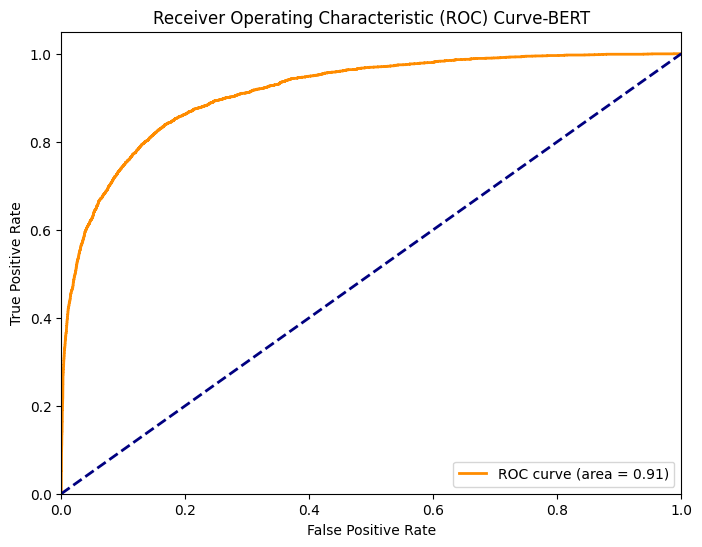

In [ ]:
fpr, tpr, _ = roc_curve(all_true_labels, all_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-BERT')
plt.legend(loc="lower right")
plt.show()

**Plotting the Average Loss Curve**

Average Training Losses: [0.6494903633637088, 0.5166644318477098, 0.4402772112677765, 0.39816308951000295, 0.3690355929286816]
Average Validation Losses: [0.5736366733591608, 0.45089916548830394, 0.4093244513298603, 0.3780661823901724, 0.36573008210101027]


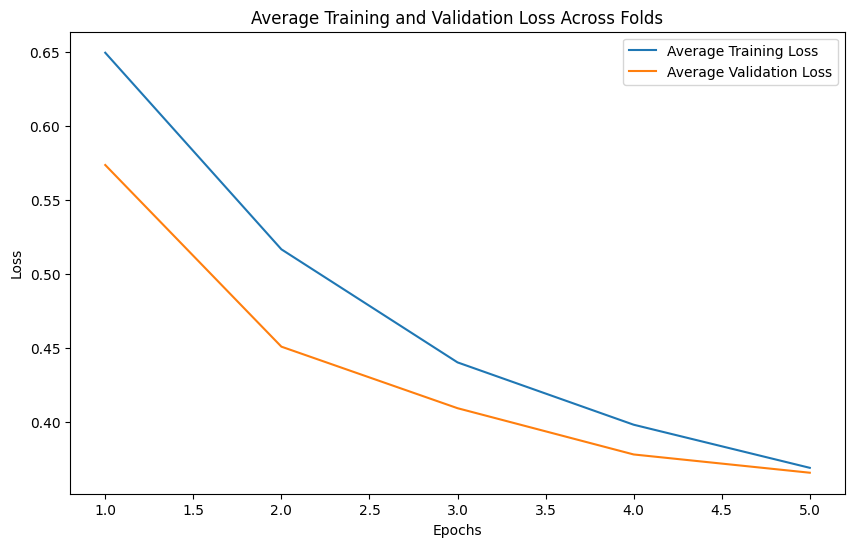

In [ ]:
average_train_losses = [sum(train_losses[i::epochs]) / kf.get_n_splits() for i in range(epochs)]
average_val_losses = [sum(val_losses[i::epochs]) / kf.get_n_splits() for i in range(epochs)]

print("Average Training Losses:", average_train_losses)
print("Average Validation Losses:", average_val_losses)

# 创建一个从1开始的x轴值列表
epochs_range = list(range(1, epochs + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, average_train_losses, label='Average Training Loss')
plt.plot(epochs_range, average_val_losses, label='Average Validation Loss')
plt.title('Average Training and Validation Loss Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Plotting the Confusion Matrix**

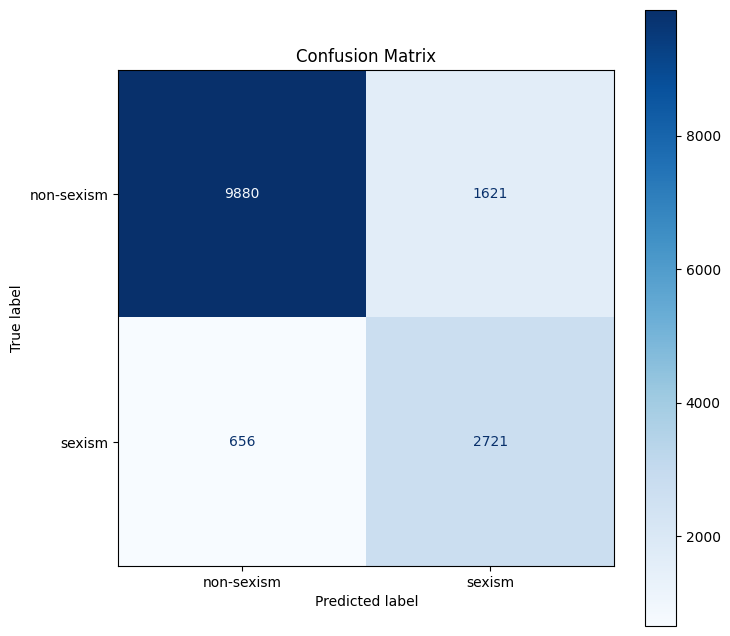

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_true_labels, all_preds_list)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()


**Logistic regression model**

**Data preprocessing**

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def clean_text_lr(text):
    """
    Cleans text by removing URLs, @mentions, non-alphabetical characters,
    converting to lowercase, and removing stopwords and lemmatizing.

    Args:
    - text (str): The text to clean.

    Returns:
    - str: The cleaned text.
    """
    # Ensure text is a string
    if not isinstance(text, str):
        return ''

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Remove non-letter characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    text = text.split()
    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    stopwords_set = set(stopwords.words('english'))
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords_set]
    # Join words back into one string
    text = ' '.join(text)
    return text

# Apply text cleaning to the dataset
df['cleaned_text_lr'] = df['Text'].apply(clean_text_lr)

# Prepare the dataset
X = df['cleaned_text_lr']
y = df['oh_label']


NameError: name 'df' is not defined

In [ ]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizing X using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Transforming the training and test data with the TF-IDF vectorizer
X_train_tfidf = tfidf_vectorizer.transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# Handling NaN values in the target variable
nan_indices = y_train.index[y_train.isna()]
X_train = X_train.drop(nan_indices)
y_train = y_train.drop(nan_indices)
# Removing the corresponding entries from the vectorized training data
X_train_tfidf = np.delete(X_train_tfidf, nan_indices, axis=0)

# Initializing the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Training the model with the vectorized training data
log_reg.fit(X_train_tfidf, y_train)

# Making predictions on the test set
y_pred = log_reg.predict(X_test_tfidf)

# Calculating the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8729838709677419


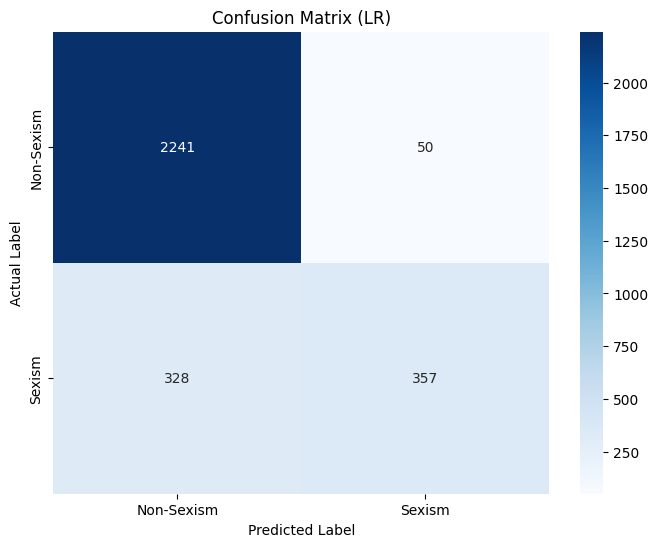

Confusion Matrix:
[[2241   50]
 [ 328  357]]


In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
# Create a heatmap from the confusion matrix with annotations and a specific color map
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Sexism", "Sexism"],
            yticklabels=["Non-Sexism", "Sexism"])
plt.ylabel('Actual Label')  # Label for the y-axis
plt.xlabel('Predicted Label')  # Label for the x-axis
plt.title('Confusion Matrix (LR)')  # Title of the plot
plt.show()  # Display the plot

# Print the confusion matrix as a text output
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

class_report = classification_report(y_test, y_pred)
print("Classification Report-LR：")
print(class_report)

NameError: name 'y_test' is not defined

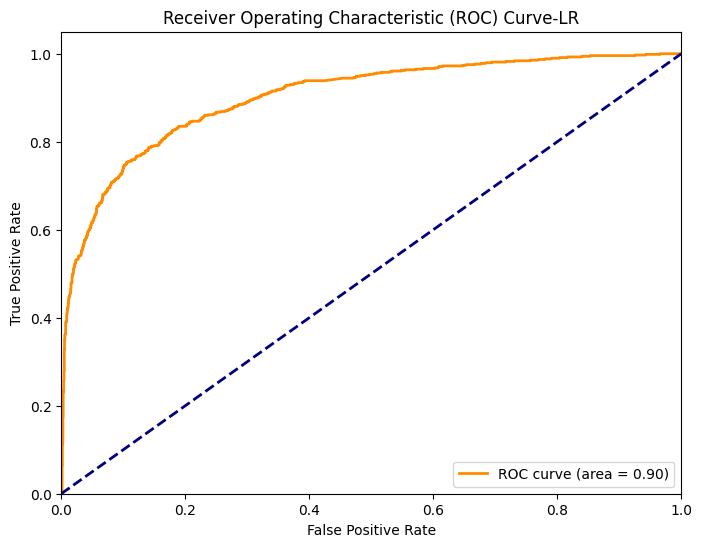

In [ ]:
#ROC-AUC
y_pred_proba = log_reg.predict_proba(X_test_tfidf)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-LR')
plt.legend(loc="lower right")
plt.show()

**Performance Evaluation and Comparison-BERT and LR**

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd

# Evaluate BERT model performance
bert_accuracy = accuracy_score(all_true_labels, all_preds_list)  # Calculate accuracy
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(all_true_labels, all_preds_list, average='binary')  # Calculate precision, recall, and F1-score
bert_auc = roc_auc_score(all_true_labels, all_pred_probs)  # Calculate ROC AUC score

# Evaluate Logistic Regression model performance
logreg_accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
logreg_precision, logreg_recall, logreg_f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Calculate precision, recall, and F1-score
logreg_proba = log_reg.predict_proba(X_test_tfidf)[:, 1]  # Get predicted probabilities
logreg_auc = roc_auc_score(y_test, logreg_proba)  # Calculate ROC AUC score

# Organize performance metrics into a dictionary
performance_metrics = {
    'Model': ['BERT', 'Logistic Regression'],
    'Accuracy': [bert_accuracy, logreg_accuracy],
    'Precision': [bert_precision, logreg_precision],
    'Recall': [bert_recall, logreg_recall],
    'F1 Score': [bert_f1, logreg_f1],
    'ROC AUC': [bert_auc, logreg_auc]
}

# Create a DataFrame from the dictionary
performance_df = pd.DataFrame(performance_metrics)

# Set the DataFrame index to the model names
performance_df.set_index('Model', inplace=True)

# Print the table
print(performance_df.to_string())


                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Model                                                                 
BERT                 0.846955    0.62667  0.805745  0.705014  0.913964
Logistic Regression  0.872984    0.87715  0.521168  0.653846  0.901525


 **Predicting Sexism in Text**

In [ ]:
def predict_sexism(sentence):
    """
    Predicts whether a sentence is sexist using both a BERT model and a logistic regression model.

    Args:
    - sentence (str): The sentence to classify.

    Returns:
    - dict: A dictionary containing predictions from both models.
    """
    # Preprocess and predict with BERT model
    bert_preprocessed = preprocess_text(sentence)
    bert_encoded = tokenizer.encode_plus(bert_preprocessed, return_tensors="pt", max_length=128, truncation=True, padding=True)
    bert_input_ids = bert_encoded['input_ids'].to(device)
    bert_attention_mask = bert_encoded['attention_mask'].to(device)
    with torch.no_grad():
        bert_outputs = model(bert_input_ids, attention_mask=bert_attention_mask)
        bert_prediction = torch.argmax(bert_outputs, dim=1).item()

    # Preprocess and predict with logistic regression model
    lr_preprocessed = clean_text_lr(sentence)
    lr_encoded = tfidf_vectorizer.transform([lr_preprocessed])
    lr_prediction = log_reg.predict(lr_encoded)[0]

    # Convert numerical predictions to text labels
    labels = ['Non-Sexism', 'Sexism']
    bert_pred_label = labels[bert_prediction]
    lr_pred_label = labels[int(lr_prediction)]

    return {
        "BERT Prediction": bert_pred_label,
        "Logistic Regression Prediction": lr_pred_label
    }


In [ ]:
#To test the function, please replace the sentence with another one you'd like to analyze.
sentence = "women should not work and stay home to take care of the children"
prediction = predict_sexism(sentence)
print(f"Predictions: {prediction}")

NameError: name 'predict_sexism' is not defined